<a href="https://colab.research.google.com/github/arkeodev/nlp/blob/main/Simple_Transformers/simple_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$$
\begin{array}{c}
\text{$\Large There\ are\ three\ classes\ of\ people:\ those\ who\ see.$} \\
\text{$\Large Those\ who\ see\ when\ they\ are\ shown.$} \\
\text{$\Large Those\ who\ do\ not\ see.$} \\
\text{$\small Leonardo\ da\ Vinci$} \\
\end{array}
$$

# Transformer Architecture

To implement the transformer architecture based on the description you've provided, let's break it down into its components and outline how each can be coded using PyTorch. The transformer model, as described in the paper "Attention is All You Need", consists of several key components: an Encoder and Decoder architecture, with each having multiple layers of self-attention and feed-forward neural networks.

This guide and explanation of the Transformer architecture draws extensively from "The Annotated Transformer" by Austin Huang, Suraj Subramanian, Jonathan Sum, Khalid Almubarak, and Stella Biderman, building upon the original work by Sasha Rush. This comprehensive article offers a detailed line-by-line implementation of the Transformer model, providing insights into its inner workings and illustrating the theoretical concepts with practical code examples. It serves as an invaluable resource for understanding and implementing the Transformer model.

## Time Complexity Comparison

<figure>
    <img src="https://raw.githubusercontent.com/arkeodev/nlp/main/Simple_Transformers/images/time-complexity-of-transformers.png" width="1000" height="300" alt="Time complexity">
    <figcaption>Time complexity</figcaption>
</figure>

The table from Vaswani et al. (2017), which is from the seminal paper "Attention is All You Need," compares different neural network layer types across three dimensions: complexity per layer, number of sequential operations, and maximum path length:

- **Self-Attention Layer**:
  - Computational complexity per layer is $ O(n^2 \cdot d) $, meaning it scales quadratically with the sequence length and linearly with the dimensionality of the representation.
  - Sequential operations are constant $ O(1) $, allowing for high parallelization during training and inference.
  - Maximum path length is also constant $ O(1) $, ensuring that long-range dependencies can be learned effectively as any position in the sequence can directly attend to any other position.

- **Recurrent Layer**:
  - Complexity is $ O(n \cdot d^2) $, which scales linearly with the sequence length, making it less efficient for longer sequences compared to self-attention.
  - Requires $ O(n) $ sequential operations, limiting parallelization and potentially increasing training time.
  - Has a linear maximum path length $ O(n) $, which can make learning long-range dependencies more challenging.

- **Convolutional Layer**:
  - Shows a complexity of $ O(k \cdot n \cdot d^2) $, where $ k $ is the kernel size, suggesting an increase in computation if larger receptive fields are needed.
  - Has constant sequential operations $ O(1) $, similar to self-attention, facilitating parallelization.
  - Exhibits a logarithmic maximum path length $ O(\log_k(n)) $, improving the learning of dependencies over recurrent layers but potentially less effective than self-attention for very long sequences.

- **Restricted Self-Attention Layer (or Local Attention)**:
  - Complexity per layer is reduced to $ O(r \cdot n \cdot d) $ by restricting attention to a window of $ r $ surrounding tokens, balancing computational efficiency and the ability to capture dependencies.
  - Maintains constant sequential operations $ O(1) $, benefiting parallelization.
  - Features a maximum path length of $ O(n/r) $, indicating a compromise in the ability to learn dependencies as the sequence length increases compared to full self-attention.

Let's dive into the self-attention mechanism, which forms the core component of transformers.

## Self-Attention

The self-attention mechanism is what allows Transformers to process data in parallel. It assigns a weight to each element in the input sequence, based on how relevant each element is to every other element.

### Description of Self Attention

Self-attention can be described with three main components: Queries, Keys, and Values.

- **Queries**: A set of vectors that is matched against the keys to decide the most important elements in the sequence.
- **Keys**: Vectors that are paired with values; they are used to extract the information that queries look for.
- **Values**: Vectors that contain the actual information of each element in the sequence that is extracted based on the weightage from the keys.

Imagine you are in a library with a huge collection of books (the sequence), and you are looking for information on a specific topic.

- The **query** is like your question about the topic you’re interested in.
- The **keys** represent the index or summary of each book.
- The **values** are the actual contents of the books.

The librarian (the self-attention mechanism) checks your question against all summaries (keys) to determine which books (values) have the information you need. This process is done simultaneously for all the questions in parallel, which is what makes the transformer model so powerful and efficient.

### Alternative Attention Approaches

- **Additive Attention**: While the scaled dot-product attention is widely used, alternative attention mechanisms exist, such as additive (or Bahdanau) attention, which uses a feed-forward network to compute attention scores instead of dot products. Each variant has its own advantages and use cases.

- **Multi-Head Attention**: The Transformer model extends the basic scaled dot-product attention mechanism through the use of multi-head attention, where the model runs several attention processes in parallel. This approach allows the model to simultaneously attend to information from different representation subspaces at different positions, improving the model's ability to capture various types of relationships in the data.

- **Self-Attention vs. Cross-Attention**: The module as described implements self-attention, where queries, keys, and values all come from the same source. In cross-attention settings, keys and values can come from a different source than queries, enabling interactions between different sequences (e.g., between an encoder and a decoder in a sequence-to-sequence model).

### Mathemetical Foundation of Attention

The following formula represents the scaled dot-product attention, which is the foundation of self-attention:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

**Components and Dimensions:**

- $( Q )$: Queries matrix of dimension $( m \times d_k )$, where $( m )$ is the number of queries and $( d_k )$ is the dimension of each query vector.
- $( K )$: Keys matrix of dimension $( n \times d_k )$, where $( n )$ is the number of keys (and values) and $( d_k )$ is the dimension of each key vector.
- $( V )$: Values matrix of dimension $( n \times d_v )$, where $( n )$ is the number of values and $( d_v )$ is the dimension of each value vector.
- $( d_k )$: Dimension of the keys (and queries), used for scaling the dot product scores.

**1. Dot Product of $( Q )$ and $( K^T )$**

- $( QK^T )$: Since $( Q )$ is $( m \times d_k )$ and $( K )$ is $( n \times d_k )$, when we take the transpose of $( K )$ to get $( K^T )$ which is $( d_k \times n )$, the resulting dot product $( QK^T )$ will be a matrix of dimension $( m \times n )$. Each element of this matrix represents a score reflecting the relevance of a query to a key.

- This step calculates the similarity between all queries and all keys, serving as the basis for determining how the values should be weighted according to each query.

**2. Scaling by $( \sqrt{d_k} )$**

- The scores in the $( m \times n )$ matrix are scaled down by $( \sqrt{d_k} )$, which doesn't change the dimensions of the matrix but normalizes the scores to prevent them from becoming too large.

- Scaling helps maintain numerical stability, particularly in the softmax step, by ensuring the scores don't lead to extremely small gradients when the dimensionality $( d_k )$ is large.

**3. Softmax Function**

- The softmax function is applied across the rows of the scaled $( m \times n )$ matrix. The dimensionality of the output remains $( m \times n )$, but now each row sums to 1, representing probabilities.

- Converting the scores to probabilities allows the model to probabilistically decide which keys (and thus, which values) are most relevant to each query, enabling a soft selection mechanism.

**4. Multiplication by $( V )$**

- The softmax output, still $( m \times n )$, is then multiplied by $( V )$, which is $( n \times d_v )$. The resulting matrix will have dimensions $( m \times d_v )$, representing the final output of the attention mechanism.

- This step effectively combines the values based on their relevance to each query, as determined by the weighted scores. The final dimension $( m \times d_v )$ corresponds to the weighted sum of values for each query, now ready for further processing in the model.


### Sample Implementation

In [1]:
import numpy as np

# Define the softmax function
def softmax(x, axis=-1):
    """Compute softmax values for each sets of scores in x over the specified axis."""
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

# Define the scaled dot product attention function
def scaled_dot_product_attention(Q, K, V):
    matmul_qk = np.matmul(Q, K.transpose(0, 2, 1))
    dk = K.shape[-1]
    scaled_attention_logits = matmul_qk / np.sqrt(dk)
    attention_weights = softmax(scaled_attention_logits)
    output = np.matmul(attention_weights, V)
    return output, attention_weights

# Let's consider two sentences for our demonstration
sentences = ["The cat sits on the mat", "A dog lies on the rug"]

# Define embeddings for each unique word in the sentences
# Embeddings are crafted so that similar words have closer embeddings
word_embeddings = {
    "the": np.array([1, 0, 0, 0, 0, 0, 0, 0]),
    "cat": np.array([0, 1, 0, 0, 0.1, 0.2, 0.3, 0.4]),
    "sits": np.array([0, 0.9, 1, 0, 0.2, 0.1, 0.4, 0.3]),
    "on": np.array([0, 0, 0, 1, 0, 0, 0, 0]),
    "mat": np.array([0, 0.8, 0.6, 0.3, 0, 0.6, 0.3, 0.2]),
    "a": np.array([1, 0, 0, 0, 0, 0, 0, 0.1]),
    "dog": np.array([0, 0.9, 0.1, 0, 0, 0.3, 0.4, 0.3]),
    "lies": np.array([0, 1, 0.8, 0.1, 0.3, 0.1, 0.4, 0.2]),
    "rug": np.array([0, 0.9, 0.6, 0.3, 0, 0.5, 0.3, 0.1])
}

# Tokenize the sentences
tokenized_sentences = [sentence.lower().split() for sentence in sentences]

# Convert sentences to embeddings using the predefined embeddings
sentence_embeddings = [[word_embeddings[word] for word in sentence] for sentence in tokenized_sentences]

# Pad sentences to the same length
max_length = max(len(sentence) for sentence in tokenized_sentences)
padded_embeddings = [np.array(sentence + [np.zeros(3)] * (max_length - len(sentence))) for sentence in sentence_embeddings]

# Stack the embeddings to create the Q, K, and V matrices
Q = np.array([np.vstack(sentence) for sentence in padded_embeddings])
K = np.array([np.vstack(sentence) for sentence in padded_embeddings])
V = np.array([np.vstack(sentence) for sentence in padded_embeddings])

# Apply the scaled dot product attention function
attention_output, attention_weights = scaled_dot_product_attention(Q, K, V)

# Let's print the attention weights for the first sentence
print("Attention weights for the first sentence:")
print(attention_weights[0])

# Let's print the attention weights for the second sentence
print("Attention weights for the second sentence:")
print(attention_weights[1])

Attention weights for the first sentence:
[[0.20795408 0.14602296 0.14602296 0.14602296 0.20795408 0.14602296]
 [0.1320772  0.20914044 0.20045296 0.1320772  0.1320772  0.194175  ]
 [0.11958619 0.18149541 0.25215275 0.11958619 0.11958619 0.20759326]
 [0.15299844 0.15299844 0.15299844 0.21788799 0.15299844 0.17011824]
 [0.20795408 0.14602296 0.14602296 0.14602296 0.20795408 0.14602296]
 [0.12397355 0.18226132 0.21520941 0.13784561 0.12397355 0.21673656]]
Attention weights for the second sentence:
[[0.20789086 0.14701445 0.1464956  0.14546337 0.20715715 0.14597857]
 [0.13342497 0.19895022 0.20393542 0.13201726 0.13201726 0.19965486]
 [0.12073931 0.18519945 0.23888728 0.12420309 0.11988857 0.2110823 ]
 [0.15216063 0.15216063 0.15763656 0.21669485 0.15216063 0.16918669]
 [0.20795408 0.14602296 0.14602296 0.14602296 0.20795408 0.14602296]
 [0.12305363 0.18544201 0.21589025 0.13633987 0.12261934 0.21665489]]


**For the first sentence "The cat sits on the mat":**

1. The attention weights for the word "the" (first row) seem to be distributed across "the", "sits", and "mat" with higher weights (0.2079) compared to "cat" and "on" (0.1460). This might indicate that the model perceives a stronger association between "the" and the action ("sits") and the object ("mat") of the sentence.

2. The word "cat" (second row) has the highest attention weight when paired with itself (0.2091) and with "sits" (0.2004), which could suggest that the model identifies "cat" and the action it's performing as key components of the sentence.

3. The word, "sits" (third row) has the highest attention weight in combination with itself (0.2521) and substantial weight with "cat" (0.1814), potentially indicating the model's understanding of the importance of the verb in the context of the subject.

4. Finally, "mat" (sixth row) pays more attention to "sits" (0.2152) as expected.

**For the second sentence "A dog lies on the rug":**

1. "Dog" (second row) shows higher attention weights for itself (0.1989) and "lies" (0.2039), which is consistent with recognizing the subject and verb relationship.

3. "Lies" (third row) has the highest weight with itself (0.2388), and a notable weight with "dog" (0.1851) and "rug" (0.2110), reinforcing the connection between the subject, object and the action.

4. "Rug" (sixth row), much like "mat" in the first sentence, shows a relatively high weight for "dog" (0.1854) and "lies" (0.2158), as expected.

In both sentences, it is evident that the attention mechanism is picking up on the grammatical structure and the relationships between subjects, verbs, and objects. It emphasizes self-attention and relationships that make sense in the context of the sentences.

# Implementation the Model

## Preliminary Setup

First, ensure all required packages are installed and import necessary libraries.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor
from torch.nn import CrossEntropyLoss
from torch.nn.functional import pad
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset

from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

import os
from os.path import exists
import math
import copy
import itertools
from collections import Counter

In [3]:
# Define device globally
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


## Helper Functions

In [4]:
# Helper function to produce N identical layers
def clones(module, N):
  "Produce N identical layers."
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# Helper function to calculate the learning rate adaptively
def calculate_learning_rate(step, model_size, factor, warmup):
  """
  It is changed the step 0 to 1 for LambdaLR function
  to avoid 0 raising to negative power.
  """
  if step == 0:
      step = 1
  return factor * (
      model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
  )

## Core Components of the Transformer

### Scaled Dot-Product Attention

The core of the transformer model is the attention mechanism.

<figure>
    <img src="https://raw.githubusercontent.com/arkeodev/nlp/main/Simple_Transformers/images/attention.png" width="180" height="300" alt="Attention Mechanism">
    <figcaption>Attention Mechanism</figcaption>
</figure>

In [5]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=None):
        super(ScaledDotProductAttention, self).__init__()
        # Initialize dropout for attention scores, if provided.
        self.dropout = nn.Dropout(dropout) if dropout is not None else None

    def forward(self, query, key, value, mask=None):
        # Dimension of the key vectors, used for scaling down the dot products.
        d_k = query.size(-1)
        # Compute the dot products between queries and keys for each batch and head,
        scores = torch.matmul(query, key.transpose(-2, -1))
        # Scale the results
        scaled_score = scores / math.sqrt(d_k)
        # Apply masking if provided (for attention to consider only certain positions).
        if mask is not None:
            scaled_score = scaled_score.masked_fill(mask == 0, -1e9)
        # Apply softmax to obtain attention probabilities.
        p_attn = F.softmax(scaled_score, dim=-1)
        # Optionally apply dropout to attention scores.
        if self.dropout is not None:
            p_attn = self.dropout(p_attn)
        # Weight the values by the computed attention probabilities.
        return torch.matmul(p_attn, value), p_attn

The `ScaledDotProductAttention` module implements the attention mechanism that is at the heart of the Transformer model's effectiveness. Its roles and effects on the structure are as follows:

- **Attention Calculation**: This module computes the attention scores by taking the dot product of the query with the key. It scales the dot product by the square root of the dimensionality of the key to prevent extremely small gradients when the dimensionality is large. This scaling helps stabilize gradients during training.

- **Masking**: The optional mask allows the model to selectively ignore certain positions within the input sequence. This is particularly useful for masking out padding tokens in the input sequence or for preventing the model from peeking at future tokens when processing sequences in an autoregressive manner (e.g., during training a language model).

- **Dropout**: Applying dropout to the attention scores is a regularization technique that helps prevent overfitting by randomly zeroing out some of the scores before computing the final attention weights.

- **Softmax**: The softmax function converts the attention scores into probabilities, ensuring that they are non-negative and sum up to 1. This step allows the model to essentially "focus" on the most relevant parts of the input.

- **Output**: The module outputs the weighted sum of the value vectors, scaled by the attention probabilities, which is then used in subsequent layers of the model. It also returns the attention probabilities themselves, which can be useful for analysis or for visualizing the model's attention.



### Multi-Head Attention

Allows the model to jointly attend to information from different representation subspaces.

<figure>
    <img src="https://raw.githubusercontent.com/arkeodev/nlp/main/Simple_Transformers/images/mutl-head-attention.png" width="180" height="300" alt="Multi Head Attention">
    <figcaption>Multi Head Attention</figcaption>
</figure>

In [6]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        # Ensure the model dimension is divisible by the number of heads.
        assert d_model % h == 0
        # Dimension of each attention head.
        self.d_k = d_model // h
        # Number of attention heads.
        self.h = h
        # Linear layers for query, key, value, and output transformation.
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        # Scaled dot-product attention mechanism.
        self.attn = ScaledDotProductAttention(dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        # Expand mask for all heads if provided.
        if mask is not None:
            mask = mask.unsqueeze(1)

        # Batch size
        nbatches = query.size(0)

        # Instead of using a fixed size, calculate the sequence length dynamically
        # based on the current shape of the query, key, and value tensors.
        seq_len = query.size(1)

        # Perform the linear operations and split into h heads,
        # adjusting the sequence length dynamically.
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # Apply attention on all the projected vectors in batch.
        x, attn_weights = self.attn(query, key, value, mask=mask)

        # Concat using a view and apply a final linear.
        # Adjust the operation to handle dynamic sequence length.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)

        return self.linears[-1](x)


The `MultiHeadedAttention` module plays a crucial role in the Transformer architecture by enabling the model to focus on different parts of the input sequence simultaneously. Here's how it fits into the overall structure and its impact:

- **Parallel Attention Heads**: This module divides the model's attention mechanism into multiple "heads," allowing the model to jointly attend to information from different representation subspaces at different positions. This parallelization helps capture more complex dependencies in the data.

- **Query, Key, Value Transformations**: Before computing attention, the module transforms the input queries, keys, and values through separate linear layers. This transformation is critical for allowing each attention head to learn different aspects of the data.

- **Scaled Dot-Product Attention**: Each head uses scaled dot-product attention to compute how much focus to put on other parts of the input sequence. The scaling factor (the square root of the dimension of the key vectors) helps stabilize the gradients during training.

- **Masking Support**: The module supports masking out certain positions within the input sequence (e.g., for ignoring padding tokens or for enforcing causality in autoregressive models), which is essential for flexible sequence processing.

- **Output Transformation**: After computing the attention in all heads, the module combines the outputs and passes them through another linear transformation to produce the final result. This step is crucial for reintegrating the information learned by each head.

### Position-wise Feed-Forward Networks

Each layer in the encoder and decoder contains a fully connected feed-forward network.

The `PositionwiseFeedForward` class is a component of the Transformer architecture, designed to process the output of the attention mechanism.

The PositionwiseFeedForward network plays a crucial role in adding depth and complexity to the Transformer model. While the attention mechanism allows the model to focus on different parts of the input sequence, the feedforward network enables complex transformations of the attention-modulated representations. This combination of attention and position-wise feedforward processing allows the Transformer to effectively capture the intricacies of sequential data.


Here's a breakdown of its structure and function:

- **Initialization (`__init__`)**:
    - **d_model**: This parameter represents the dimensionality of the input and output of this feedforward network. It's consistent with the model's overall dimensionality, ensuring that the input and output of the feedforward network can seamlessly integrate with other parts of the Transformer.

    - **d_ff**: This is the dimensionality of the hidden layer within the feedforward network. Typically, `d_ff` is significantly larger than `d_model`, allowing the network to capture more complex interactions in the data. This expansion and subsequent projection back to `d_model` is a common technique for increasing the expressiveness of neural networks.

    - **dropout**: Specifies the dropout rate for regularization. Dropout is applied to the output of the first activation function.


- **Forward Pass (`forward`)**:
    - The input `x` is first passed through a linear transformation (`self.w_1`), increasing its dimensionality from `d_model` to `d_ff`. This is followed by a ReLU activation function to introduce non-linearity, enabling the network to model complex relationships.

    - A dropout is applied after the ReLU function, randomly setting a fraction of its inputs to zero, which helps in regularization.

    - Finally, the output from the dropout layer is passed through another linear transformation (`self.w_2`) to project it back to the original dimensionality (`d_model`). This ensures that the output of the feedforward network can be fed directly into subsequent layers or components of the Transformer.

In [7]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

### Embeddings


Convert input tokens and output tokens to vectors.

`Embeddings` are the entry point of textual (or any token-based) data into the Transformer model, transforming discrete token IDs into dense vectors that can carry semantic information. These vectors are then processed through the model's subsequent layers. The scaling factor $(\sqrt{d_{model}})$ is applied to give the embeddings a similar scale to the model's internal activations, aiming to facilitate optimization.


Here's a breakdown of its components and functionality:

- **Initialization (`__init__`)**:
    - **d_model**: This parameter represents the size of the embedding vectors. In the context of Transformers, `d_model` is a fixed-size dimension that all embeddings and subsequent layers adhere to, ensuring uniformity across the model's architecture. It's a critical hyperparameter that influences the model's capacity to encode information.

    - **vocab**: This is the size of the vocabulary, representing the total number of unique tokens that the model can recognize. The `vocab` size determines the number of rows in the embedding matrix, where each row corresponds to a specific token in the vocabulary.

- **Forward Pass (`forward`)**:
    - The `forward` method takes an input tensor `x` containing token IDs and returns their corresponding embeddings. The embeddings are scaled by the square root of `d_model`, a normalization step recommended in the original Transformer paper to reduce the variance of the embeddings, helping stabilize the learning process.


In [8]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.embedding = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.embedding(x.long()) * math.sqrt(self.d_model)


### Positional Embedding

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.

The `PositionalEncoding` class is a component designed to add information about the position of tokens within a sequence to the embeddings in a Transformer model. Since the Transformer architecture relies on attention mechanisms that do not inherently understand sequence order (unlike RNNs or LSTMs), positional encodings are crucial for enabling the model to consider the order of tokens when processing text or other sequential data. Without them, the model would treat sequences as unordered sets of tokens, significantly reducing its ability to perform tasks that rely on the sequential nature of the data, such as language understanding, translation, and generation.


Here's a detailed explanation:


- **Initialization (`__init__`)**:
    - **d_model**: The dimensionality of the model's embeddings, which is the size of the vectors representing each token. Positional encodings must match this dimensionality to be added to the token embeddings.

    - **dropout**: The dropout rate for regularization. After adding positional encodings to the token embeddings, dropout is applied to the combined embeddings to prevent overfitting.

    - **max_len**: The maximum length of the input sequences that the model can handle. This parameter defines the size of the positional encoding matrix, ensuring that every position in a sequence, up to `max_len`, has a unique positional encoding vector.

    - **pe (Positional Encoding Matrix)**: A precomputed matrix where each row represents the positional encoding for a specific position in a sequence. The encodings alternate between sine and cosine functions across different dimensions, allowing the model to distinguish positions based on these patterns. The use of sine and cosine functions helps the model to learn to attend to relative positions since the encoding for a position is a function of its distance from other positions.

- **Forward Pass (`forward`)**:
    - The method receives the token embeddings `x` and adds the positional encodings to them based on the length of the input sequence. The positional encoding vectors are not learned but are a fixed function of the position. Adding these encodings to the embeddings allows the model to consider the position of tokens when processing sequences.
    
    - The result is then passed through a dropout layer for regularization before being returned.

In [9]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Precompute the positional encodings in log space.
        # pe is the positional encoding matrix where each row corresponds to a position
        # and each column corresponds to a dimension in the d_model space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)  # Generate a column vector of positions.
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )  # Generate the divisors for the sine and cosine functions.
        pe[:, 0::2] = torch.sin(position * div_term)  # Apply sine to even indices in the dimensions.
        pe[:, 1::2] = torch.cos(position * div_term)  # Apply cosine to odd indices.
        pe = pe.unsqueeze(0)  # Add a batch dimension.
        self.register_buffer("pe", pe)  # Register pe as a buffer that is not a model parameter.

    def forward(self, x):
        # Add positional encoding to each embedding vector in the batch.
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)  # Ensures gradients are not computed for pe.
        return self.dropout(x)  # Apply dropout and return the result.


### Layer Normalisation

We employ a residual connection around each of the two sub-layers, followed by layer normalization

In the Transformer model, layer normalization is applied within both the encoder and decoder components.

Layer Normalization works by normalizing the inputs across the features for each data sample in a batch. It's particularly effective in recurrent neural networks and has been beneficial in Transformer models. By normalizing the inputs, it helps control the scale of gradients, making the optimization landscape smoother, which often leads to faster training and better generalization.

Here's a detailed explanation:

- **Learnable Parameters (`self.gamma` and `self.beta`)**: Unlike batch normalization, which normalizes across the batch dimension, layer normalization performs normalization for each sample independently and uses learnable parameters to scale (`gamma`) and shift (`beta`) the normalized values.

- **Epsilon (`self.eps`)**: A small constant added to the standard deviation to avoid division by zero.

- **Normalization Process**: The forward method computes the mean and standard deviation for each input sample across its features. It then normalizes the inputs by subtracting the mean and dividing by the standard deviation, adjusted by `eps`. Finally, it applies the learned scaling and shifting parameters to each feature.

In [10]:
class LayerNorm(nn.Module):
    "Construct a layernorm module"

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        # Learnable Parameters to scale and shift the normalized values.
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps  # Small epsilon value to prevent division by zero in normalization

    def forward(self, x):
        # Calculate the mean of the features.
        mean = x.mean(-1, keepdim=True)
        # Calculate the standard deviation of the features.
        std = x.std(-1, keepdim=True)
        # Normalize the features. The normalization formula is:
        # normalized_x = gamma * (x - mean) / (std + epsilon) + beta
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

### Sublayer Connection

The `SublayerConnection` module is designed to wrap around any sub-layer of the Transformer model, such as a self-attention layer or a position-wise feedforward network, to incorporate a residual connection and layer normalization around that sub-layer. This is critical for the model's ability to train deeply.

- **Layer Normalization**: The input to the sub-layer is first normalized. Normalization stabilizes the learning process by ensuring that the input distributions to layers do not shift dramatically.

- **Sub-layer Functionality**: The `sublayer` argument represents any function or module that takes the normalized input and produces an output of the same dimension (`d_model`). This design allows the `SublayerConnection` module to be agnostic to the specific type of sub-layer it is augmenting.

- **Dropout and Residual Connection**: Dropout is applied to the output of the sub-layer for regularization. The dropout-enhanced output is then added to the original input `x` to form a residual connection. This connection allows gradients to flow directly through the network, mitigating the vanishing gradient problem and enabling the effective training of deep networks.

- **Output Dimension Consistency**: The requirement that all sub-layers and embedding layers produce outputs of dimension `d_model` ensures consistency and simplicity in the model architecture. This uniformity is crucial for stacking multiple layers and for the effectiveness of residual connections.

That is, the output of each sub-layer is

$$
LayerNorm(x+Sublayer(x))
$$

where Sublayer(x) is the function implemented by the sub-layer itself.

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{model} = 512$


In [11]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        # Normalizes the input features across the features dimension.
        self.norm = LayerNorm(size)
        # Dropout module
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        # Normalize the input, pass through the sublayer, apply dropout,
        # then add the input x for the residual connection.
        # This ensures that the input can flow directly (or with minimal
        # modification) through the layers of the network,
        # preventing the vanishing gradients problem in deep networks.
        return x + self.dropout(sublayer(self.norm(x)))

### Generator

The `Generator` class in a Transformer model architecture is the final step in the model's decoder that maps the decoder output to a probability distribution over the vocabulary.

In a typical sequence generation task, this `Generator` module's output can be used during training to calculate the loss by comparing the predicted log probabilities against the ground truth. During inference, the logits (before the softmax) are often used with decoding strategies like greedy decoding, beam search, or sampling to select the next token in the sequence.

Here's detailed explanations:

- **Projection**: The linear layer (`nn.Linear`) projects the high-dimensional decoder outputs (which encode the semantic information of the input sequence and the so-far generated output sequence) down to the vocabulary space. The output of this layer is a set of logits, with one logit per vocabulary token, for each position in the input sequence.

- **Log Softmax**: The softmax function is commonly used to convert logits to probabilities, ensuring that the output values are non-negative and sum to one, thus forming a valid probability distribution. The use of `log_softmax` instead of plain `softmax` is for numerical stability, especially useful in the context of calculating the loss during training (e.g., when using the Negative Log Likelihood loss).

In [12]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        # Linear transformation that projects from model dimension (d_model) to vocabulary size.
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        """
        Applies the linear transformation followed by log softmax.

        Parameters:
        - x: The input tensor with shape [batch size, sequence length, d_model],
             representing the output from the Transformer's final decoder layer.

        Returns:
        - Log probabilities of each token in the vocabulary for each position
          in the sequence and for each sequence in the batch.
        """
        return F.log_softmax(self.proj(x), dim=-1)

### Encoder Layer

The encoder is composed of a stack of $N = 6$ identical layers.

<figure>
    <img src="https://raw.githubusercontent.com/arkeodev/nlp/main/Simple_Transformers/images/encoder.png" width="200" height="400" alt="Encoder">
    <figcaption>Encoder</figcaption>
</figure>

The `Encoder` and `EncoderLayer` classes are fundamental components of the Transformer model's encoder architecture. The encoder's role is to process the input sequence and generate a set of representations that capture the semantics of the input sequence, considering both the content and the context around each token. These representations are then used by the decoder to generate the output sequence.

Here's a breakdown of these components with detailed comments:


- **Encoder**: The encoder takes the entire input sequence and transforms it into a continuous representation that holds the contextual information of every token. This is achieved through a series of encoder layers that each perform self-attention and position-wise feed-forward computations.

- **EncoderLayer**: Each encoder layer first processes its input with a self-attention mechanism, allowing each position in the input to attend over all positions in the input sequence to capture contextual information. It then applies a position-wise feed-forward network to each position independently. Both the self-attention and feed-forward networks are wrapped with residual connections and layer normalization (encapsulated by the `SublayerConnection` module), which helps stabilize training and allows for deeper models.

In [13]:
class Encoder(nn.Module):
    """
    Core encoder is a stack of N layers.
    The encoder processes the input sequence in a series of steps,
    each performed by an EncoderLayer.
    All layers in the encoder are identical but do not share weights.
    """

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        # Clones the given layer N times to create a stack of N identical layers.
        self.layers = clones(layer, N)
        # Applies layer normalization to the output of the last encoder layer.
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        """
        Pass the input (and mask) through each layer in turn.

        Parameters:
        - x: The input sequence to the encoder.
        - mask: A mask tensor indicating which positions are valid
        (e.g., to exclude padding positions from attention computations).

        Returns:
        - The output of the last layer normalization, representing
        the encoder's final representations of the input sequence.
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [14]:
class EncoderLayer(nn.Module):
    """
    Encoder is made up of self-attention and feed-forward networks.
    This design allows each token in the input sequence to attend
    to all tokens in the same sequence (self-attention),
    followed by position-wise feed-forward processing.
    """

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        # The self-attention mechanism.
        self.self_attn = self_attn
        # The position-wise feed-forward network.
        self.feed_forward = feed_forward
        # Two instances of SublayerConnection, which apply residual connections
        # and layer normalization around the sub-layers.
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        # The size of the input and output dimension of the layer.
        self.size = size

    def forward(self, x, mask):
        """
        Process the input x through the self-attention and feed-forward networks sequentially,
        with each being wrapped in a SublayerConnection to include residual connections and normalization.

        Parameters:
        - x: The input to the encoder layer.
        - mask: A mask tensor for the self-attention mechanism to ignore certain positions.

        Returns:
        - The output of the encoder layer, after processing by self-attention and feed-forward networks.
        """
        # Apply self-attention sub-layer, with residual connection and normalization.
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # Apply feed-forward sub-layer, with residual connection and normalization.
        return self.sublayer[1](x, self.feed_forward)

### Decoder Layer

The decoder is also composed of a stack of $N=6$ identical layers.

<figure>
    <img src="https://raw.githubusercontent.com/arkeodev/nlp/main/Simple_Transformers/images/decoder.png" width="200" height="480" alt="Decoder">
    <figcaption>Decoder</figcaption>
</figure>

The `Decoder` and `DecoderLayer` classes are central components of the Transformer model's decoder side, designed for sequence generation tasks. The decoder processes the encoder's output (referred to as "memory" here) along with its own input to generate the final output sequence.

Here's a detailed breakdown with comments for clarity:

- **Decoder**: Similar to the encoder, the decoder is composed of a stack of layers. However, the decoder layers also include cross-attention mechanisms that allow the decoder to focus on relevant parts of the input sequence as it generates each token of the output sequence. The decoder uses masking to ensure that predictions for a given position can only depend on known outputs at positions before it, not future positions.

- **DecoderLayer**: Each decoder layer has three main components:
    - **Self-Attention Layer**: Allows each position in the decoder to attend to all positions up to and including that position in the decoder sequence.
    - **Cross-Attention Layer**: Allows each position in the decoder to attend to all positions in the encoder sequence, integrating information from the input sequence.
    - **Feed-Forward Network**: Processes each position of the decoder output in isolation, further transforming the data after integrating information from the encoder and previous decoder outputs.

In [15]:
class Decoder(nn.Module):
    """
    Generic N layer decoder with masking.

    The decoder is responsible for generating the output sequence by processing
    the encoder output and the previous decoder outputs. It includes mechanisms
    for self-attention within the decoder and cross-attention to the encoder outputs.
    """

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        # Stack of N identical layers.
        self.layers = clones(layer, N)
        # Layer normalization applied to the output of the final layer.
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        Pass the input through each layer in turn.

        Parameters:
        - x: Input to the decoder, typically the previous output.
        - memory: Output from the encoder to be used in cross-attention.
        - src_mask: Mask for the encoder output.
        - tgt_mask: Mask for the decoder input to prevent attending to future tokens.

        Returns:
        - The output of the decoder after processing through N layers and normalization.
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.

In [16]:
class DecoderLayer(nn.Module):
    """
    Decoder is made of self-attention, source-attention, and feed forward networks.

    Each layer in the decoder includes two attention mechanisms: one for attending to
    the previous decoder outputs (self-attention) and one for attending to the encoder
    outputs (source-attention). This is followed by a position-wise feed-forward network.
    """

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size  # Size of the input dimension.
        # Self-attention mechanism for attending to previous decoder outputs.
        self.self_attn = self_attn
        # Source-attention mechanism for attending to encoder outputs.
        self.src_attn = src_attn
        # Position-wise feed-forward network.
        self.feed_forward = feed_forward
        # Residual connections around each of the sub-layers.
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        Process input through self-attention, source-attention, and feed-forward layers.

        Parameters:
        - x: Input to the decoder layer.
        - memory: Encoder outputs.
        - src_mask: Mask for the encoder outputs.
        - tgt_mask: Mask for the decoder inputs to ensure causality.

        Returns:
        - The output of the decoder layer after processing.
        """
        m = memory
        # Apply self-attention with causality mask to prevent forward-looking.
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # Apply source-attention, attending to encoder outputs.
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        # Apply the feed-forward network.
        return self.sublayer[2](x, self.feed_forward)

### Subsequent Mask

The `subsequent_mask` function is a crucial component in the Transformer model, specifically within the decoder. It is designed to prevent positions from "peeking" into the future by masking out subsequent positions during the self-attention calculation in the decoder layers. This masking strategy is vital for ensuring that the prediction for a given position in the output sequence can only depend on the known outputs at positions before it, thereby enforcing causality in the model's predictions. Here's an explanation of how the function works and its significance:


- **Causality in Decoding**: In the context of sequence generation, causality ensures that the model cannot rely on future tokens when predicting the current token. This is essential for tasks like text generation, where the model generates one token at a time.

- **Self-Attention Masking**: The Transformer model uses self-attention mechanisms to weigh the importance of different positions in the input data. For the decoder, the `subsequent_mask` is applied to the attention scores before the softmax step, effectively setting the scores for disallowed positions to negative infinity (after applying a log mask). This ensures that these positions do not contribute to the softmax output.

- **Training vs. Inference**: During training, the Transformer model can process entire sequences in parallel, which greatly improves efficiency. The `subsequent_mask` enables this parallelization by ensuring that the model still respects the sequential nature of the data, even when processing many positions simultaneously. During inference, the model generates one token at a time, and the mask ensures that each prediction only uses appropriate past context.

In [17]:
def subsequent_mask(size):
    """
    Creates a mask to prevent attention to subsequent positions.

    Parameters:
    - size: The size of the sequence (length of the sequence).

    Returns:
    - A mask tensor of shape (1, size, size) where positions are filled with False (0)
      for allowed attentions and True (1) for positions that should be masked.
      This means that for any given row in the mask, positions to the right
      (i.e., subsequent positions) are masked with True.
    """
    # Create a square matrix of size `size` filled with ones on and above the diagonal.
    subsequent_mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.uint8)
    # Invert the mask: positions with ones become zeros (masked) and vice versa.
    return subsequent_mask == 0

## Full Transformer Model

<figure>
    <img src="https://raw.githubusercontent.com/arkeodev/nlp/main/Simple_Transformers/images/overall-architecture-of-transformers.png" width="400" height="400" alt="Transformers Architecture">
    <figcaption>Transformers Architecture</figcaption>
</figure>

Now, let's put together the main Transformer architecture combining the encoder, decoder, and other components previously described.

In [18]:
class Transformer(nn.Module):

    def __init__(self, src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1, device=None):
        super(Transformer, self).__init__()
         # Set device attribute early, before other initializations
        self.device = device
        # Utility for deep copying modules (used for encoder/decoder layers and components).
        c = copy.deepcopy
        # Set vocab sizes
        self.src_vocab_size = src_vocab
        self.tgt_vocab_size = tgt_vocab
        # Multi-headed attention mechanism.
        attn = MultiHeadedAttention(h, d_model)
        # Position-wise feed-forward network.
        ff = PositionwiseFeedForward(d_model, d_ff, dropout)
        # Positional encoding for input sequences.
        position = PositionalEncoding(d_model, dropout)
        # Encoder consisting of N layers.
        self.encoder = Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N)
        # Decoder also consisting of N layers but with its own self-attention mechanism for masked attention.
        self.decoder = Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N)
        # Embedding layers for source and target sequences, with positional encodings added.
        self.src_embed = nn.Sequential(Embeddings(d_model, self.src_vocab_size), c(position))
        self.tgt_embed = nn.Sequential(Embeddings(d_model, self.tgt_vocab_size), c(position))
        # Final linear and softmax layer to generate predictions.
        self.generator = Generator(d_model, tgt_vocab)

        # Initialize parameters with Xavier uniform distribution for better convergence.
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

        self.to(self.device)

    def forward(self, src, tgt, src_mask, tgt_mask):
        # Encodes the source sequence and then decodes it into the target sequence.
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        # Pass the source sequence and mask through the encoder.
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        # Decode the encoded source sequence (memory) into the target sequence.
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)


### Inference Test

In [19]:
# Define a simple target vocabulary mapping
tgt_vocab = {
    '<pad>': 0,
    '<bos>': 1,
    '<eos>': 2,
    '<unk>': 3,  # Tokens for unknown words
    # Example token mappings (you would typically have more tokens based on your dataset)
    'hello': 4,
    'world': 5,
    "how": 6,
    "are": 7,
    "you": 8,
    "yes": 9,
}

# Define a similar source vocabulary for completeness (used when initializing the Transformer)
src_vocab = {
    '<pad>': 0,
    '<bos>': 1,
    '<eos>': 2,
    '<unk>': 3,
    # Source tokens
    'hallo': 4,
    'welt': 5,
    "wie": 6,
    "bist": 7,
    "du": 8,
    "ja": 9,
}

# Instantiate Transformer model with the vocab sizes
test_model = Transformer(
    src_vocab=len(src_vocab),
    tgt_vocab=len(tgt_vocab),
    N=2,
    d_model=512,
    d_ff=2048,
    h=8,
    dropout=0.1,
    device=device
)

def inference_test(test_model, tgt_vocab):
    test_model = test_model.to(device)
    test_model.eval()

    # Ensure src indices are within vocabulary range
    src_indices = [min(index, len(src_vocab) - 1) for index in [1, 2, 3, 4, 5, 6, 7, 8, 9, 4]]
    src = torch.LongTensor([src_indices]).to(device)

    src_mask = torch.ones(1, 1, 10).to(device)
    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src).fill_(tgt_vocab['<bos>']).to(device)

    for _ in range(9):
        tgt_mask = subsequent_mask(ys.size(1)).type_as(src.data)
        out = test_model.decode(memory, src_mask, ys, tgt_mask)
        out_probs = test_model.generator(out[:, -1])
        _, next_word = torch.max(out_probs, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys, torch.tensor([[next_word]]).type_as(src.data)], dim=1)

    print("Example Untrained Model Prediction:", ys)

def run_tests():
    # Run the inference test 10 times to demonstrate the generation process.
    for _ in range(10):
        inference_test(test_model, tgt_vocab)

run_tests()

Example Untrained Model Prediction: tensor([[1, 2, 9, 2, 9, 2, 9, 2, 5, 2]], device='cuda:0')
Example Untrained Model Prediction: tensor([[1, 2, 9, 2, 9, 2, 9, 2, 5, 2]], device='cuda:0')
Example Untrained Model Prediction: tensor([[1, 2, 9, 2, 9, 2, 9, 2, 5, 2]], device='cuda:0')
Example Untrained Model Prediction: tensor([[1, 2, 9, 2, 9, 2, 9, 2, 5, 2]], device='cuda:0')
Example Untrained Model Prediction: tensor([[1, 2, 9, 2, 9, 2, 9, 2, 5, 2]], device='cuda:0')
Example Untrained Model Prediction: tensor([[1, 2, 9, 2, 9, 2, 9, 2, 5, 2]], device='cuda:0')
Example Untrained Model Prediction: tensor([[1, 2, 9, 2, 9, 2, 9, 2, 5, 2]], device='cuda:0')
Example Untrained Model Prediction: tensor([[1, 2, 9, 2, 9, 2, 9, 2, 5, 2]], device='cuda:0')
Example Untrained Model Prediction: tensor([[1, 2, 9, 2, 9, 2, 9, 2, 5, 2]], device='cuda:0')
Example Untrained Model Prediction: tensor([[1, 2, 9, 2, 9, 2, 9, 2, 5, 2]], device='cuda:0')


# Data Preparation

## Data Download

In [20]:
! pip install torch torchtext spacy -q

In [21]:
! pip install portalocker -q

## DataLoader

In [22]:
! python -m spacy download en_core_web_sm -q
! python -m spacy download de_core_news_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [23]:
spacy_de = spacy.load("de_core_news_sm")
spacy_en = spacy.load("en_core_web_sm")

# Tokenization functions
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

# Create a reverse vocabulary mapping
def reverse_vocab(vocab):
    return {index: token for token, index in vocab.items()}

# Data processing function to convert texts to tensors
def process_data(dataset, src_vocab, tgt_vocab):
    processed_data = []
    for src, tgt in dataset:
        src_indices = [src_vocab.get(token, src_vocab["<unk>"]) for token in tokenize_de(src)]
        tgt_indices = [tgt_vocab.get(token, tgt_vocab["<unk>"]) for token in tokenize_en(tgt)]
        processed_data.append((torch.tensor(src_indices), torch.tensor(tgt_indices)))
    return processed_data

# Vocabulary building function
def build_vocab(tokenized_texts, min_freq=1):
    # Count the frequency of tokens in the tokenized texts
    counter = Counter(itertools.chain(*tokenized_texts))

    # Filter tokens by min_freq and sort by frequency in descending order
    vocab_tokens = sorted([token for token, freq in counter.items() if freq >= min_freq], key=lambda token: -counter[token])

    # Add special tokens to the beginning of the vocab_tokens list
    specials = ["<bos>", "<eos>", "<unk>", "<pad>"]
    vocab_tokens = specials + vocab_tokens

    # Create a token to index mapping
    token_to_idx = {token: idx for idx, token in enumerate(vocab_tokens)}

    return token_to_idx

# DataLoader preparation
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)

    # Convert lists of indices to tensors
    src_batch = [torch.tensor(src, dtype=torch.long) for src in src_batch]
    tgt_batch = [torch.tensor(tgt, dtype=torch.long) for tgt in tgt_batch]

    # Pad sequences within the batch
    # pad_sequence automatically pads to the longest sequence in the batch
    src_batch_padded = pad_sequence(src_batch, padding_value=src_vocab["<pad>"], batch_first=True)
    tgt_batch_padded = pad_sequence(tgt_batch, padding_value=tgt_vocab["<pad>"], batch_first=True)

    return src_batch_padded, tgt_batch_padded

# Dataset loading
train_dataset = Multi30k(split='train', language_pair=('de', 'en'))
train_dataset_list = list(train_dataset)

# Tokenize and build vocab
tokenized_de_texts = [tokenize_de(text) for text, _ in train_dataset_list]
tokenized_en_texts = [tokenize_en(text) for _, text in train_dataset_list]

src_vocab = build_vocab(tokenized_de_texts)
tgt_vocab = build_vocab(tokenized_en_texts)

rev_src_vocab = reverse_vocab(src_vocab)
rev_tgt_vocab = reverse_vocab(tgt_vocab)

# Process the train dataset
train_data = process_data(train_dataset, src_vocab, tgt_vocab)

train_loader = DataLoader(CustomDataset(train_data), batch_size=32, collate_fn=collate_fn, shuffle=True, drop_last=True)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


# Training

### Regularization with Label Smoothing

#### Why Label Smoothing?

Label smoothing is a regularization technique that tempers the model's confidence in its predictions by adjusting the target labels to be less deterministic. It has been shown to improve model generalization and robustness, evidenced by enhancements in accuracy and BLEU score for tasks like machine translation.

#### How Label Smoothing Works

Instead of targeting a hard one-hot encoded vector, label smoothing modifies the target distribution by allocating a portion of the confidence (1 - smoothing factor) to the correct label and distributing the remaining smoothing mass uniformly across all other labels in the vocabulary.

#### Implementation in PyTorch

We use PyTorch's `nn.KLDivLoss` to implement label smoothing as it allows us to measure the divergence between the smoothed label distribution and the predictions.

In [24]:
class LabelSmoothing(nn.Module):
    """
    Implements label smoothing.
    """
    def __init__(self, size, padding_idx, smoothing=0.0):
        """
        size: the size of the class dimension. Typically, this is the number of
              classes.
        padding_idx: the index used for the padding token. This is to ensure
                     padding tokens do not affect the loss.
        smoothing: the smoothing value. It distributes confidence across
                   non-target classes to avoid the model becoming overconfident.
        """
        super(LabelSmoothing, self).__init__()
        # Defines the Kullback-Leibler divergence loss with 'batchmean' reduction.
        self.criterion = nn.KLDivLoss(reduction="batchmean")
        self.padding_idx = padding_idx
        # The confidence in the target class is 1.0 minus the smoothing value.
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None  # True distribution placeholder after smoothing.

    def forward(self, x, target):
        """
        Forward pass for calculating the smoothed label loss.

        x: the logits output from the model. The log probabilities (after
           applying log_softmax).
        target: the ground truth labels.
        """
        # Ensures the input has the correct class dimension size.
        assert x.size(1) == self.size
        # Clone the input to create a base for the true distribution.
        true_dist = x.data.clone()
        # Fill the true distribution with a base value of smoothing divided by
        # the number of non-padding, non-target classes.
        true_dist.fill_(self.smoothing / (self.size - 2))
        # Assign the confidence value to the correct class locations.
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        # Ensure the padding index in the true distribution is set to 0, so it
        # doesn't contribute to the loss.
        true_dist[:, self.padding_idx] = 0
        # Find any padding tokens in the target to mask them out in the true
        # distribution.
        mask = torch.nonzero(target.data == self.padding_idx, as_tuple=False)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        # Update the true distribution in the class instance and ensure no
        # gradient is computed for it.
        self.true_dist = true_dist.requires_grad_(False)
        # Calculate and return the KL divergence loss between the model's log
        # probabilities and the smoothed true distribution.
        return self.criterion(x, true_dist)


**Visualization of Label Smoothing**  
We can visualize how label smoothing affects the target distribution for a better understanding.

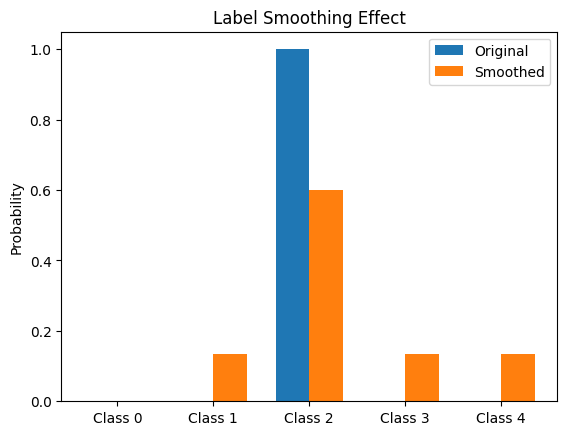

In [25]:
def visualize_label_smoothing_comparison_matplotlib():
    # Create a LabelSmoothing instance
    ls = LabelSmoothing(size=5, padding_idx=0, smoothing=0.4)
    # Simulated prediction
    prediction = torch.FloatTensor([[0, 0.4, 0.6, 0.0, 0.0]])
    # Target class
    target = torch.LongTensor([2])
    # Apply label smoothing
    ls(prediction.log(), target)
    # Extract the true distribution after label smoothing
    smoothed_dist = ls.true_dist.numpy().flatten()

    # Assuming a hypothetical original distribution with full confidence in the correct class
    original_dist = np.zeros_like(smoothed_dist)
    original_dist[target] = 1.0

    # Plotting
    labels = [f"Class {i}" for i in range(5)]
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, original_dist, width, label='Original')
    rects2 = ax.bar(x + width/2, smoothed_dist, width, label='Smoothed')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Probability')
    ax.set_title('Label Smoothing Effect')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

visualize_label_smoothing_comparison_matplotlib()


This code snippet will produce a bar chart visualizing the probabilities of each class after applying label smoothing to a single prediction. It illustrates how label smoothing distributes some probability mass to incorrect classes, reducing the model's confidence in its predictions.

This class get logits as inputs and apply `log_softmax` on it. Then applies `label smoothing`.

In [26]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y):
        x = self.generator(x)
        sloss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1))
        return sloss

### Training Loop

In [27]:
def train_transformer(model, data_loader, tgt_vocab, num_epochs=10, learning_rate=1e-3, save_path='best_model.pth'):
    model.train()

    optimizer = Adam(model.parameters(), lr=learning_rate)
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: calculate_learning_rate(
            step, model.src_embed[0].d_model, factor=1, warmup=400
        ),
    )
    ls = LabelSmoothing(size=len(tgt_vocab), padding_idx=tgt_vocab["<pad>"], smoothing=0.1)
    criterion = SimpleLossCompute(model.generator, ls)

    # Initialize variables for tracking the best loss and model
    best_loss = float('inf')

    for epoch in range(num_epochs):
        total_loss = 0
        for i, (src, tgt) in enumerate(data_loader):
            src, tgt = src.to(device), tgt.to(device)

            src_mask = (src != tgt_vocab['<pad>']).unsqueeze(-2)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            tgt_mask = (tgt_input != tgt_vocab['<pad>']).unsqueeze(-2) & subsequent_mask(tgt_input.size(-1)).type_as(tgt_input)

            optimizer.zero_grad()

            output = model(src, tgt_input, src_mask, tgt_mask)
            tgt_output_flat = tgt_output.contiguous().view(-1)

            loss = criterion(output, tgt_output_flat)
            loss.backward()

            optimizer.step()
            lr_scheduler.step()

            total_loss += loss.item()

            # Log progress every 100 batches
            if (i + 1) % 100 == 0:
                print(f'Epoch {epoch}, Batch {i+1}, Loss: {loss.item()}')

        average_loss = total_loss / len(data_loader)
        print(f'Epoch {epoch}, Average Loss: {average_loss}')

        # Checkpoint the model if it has improved
        if average_loss < best_loss:
            best_loss = average_loss
            print(f'Saving new best model with average loss {average_loss}')
            torch.save(model.state_dict(), save_path)

# Initialize model
transformer_model = Transformer(src_vocab=len(src_vocab), tgt_vocab=len(tgt_vocab), N=6, d_model=512, d_ff=2048, h=8, dropout=0.1, device=device)

# Usage example assuming model, data_loader, tgt_vocab are defined:
train_transformer(transformer_model, train_loader, tgt_vocab, num_epochs=10, learning_rate=1e-3, save_path='best_transformer_model.pth')


/tmp/ipykernel_111/3517328016.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src_batch = [torch.tensor(src, dtype=torch.long) for src in src_batch]
/tmp/ipykernel_111/3517328016.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgt_batch = [torch.tensor(tgt, dtype=torch.long) for tgt in tgt_batch]


Epoch 0, Batch 100, Loss: 4.005550861358643
Epoch 0, Batch 200, Loss: 3.7602455615997314
Epoch 0, Batch 300, Loss: 3.9017333984375
Epoch 0, Batch 400, Loss: 4.062898635864258
Epoch 0, Batch 500, Loss: 4.6021342277526855
Epoch 0, Batch 600, Loss: 4.24379301071167
Epoch 0, Batch 700, Loss: 4.219157695770264
Epoch 0, Batch 800, Loss: 4.352713584899902
Epoch 0, Batch 900, Loss: 3.2669332027435303
Epoch 0, Average Loss: 3.8631522344963964
Saving new best model with average loss 3.8631522344963964
Epoch 1, Batch 100, Loss: 3.200585126876831
Epoch 1, Batch 200, Loss: 3.4524765014648438
Epoch 1, Batch 300, Loss: 3.005319833755493
Epoch 1, Batch 400, Loss: 3.929370403289795
Epoch 1, Batch 500, Loss: 3.371458053588867
Epoch 1, Batch 600, Loss: 2.9530580043792725
Epoch 1, Batch 700, Loss: 3.887415885925293
Epoch 1, Batch 800, Loss: 2.858217477798462
Epoch 1, Batch 900, Loss: 3.571568012237549
Epoch 1, Average Loss: 3.4363396720380974
Saving new best model with average loss 3.4363396720380974
Epoc

# Translate Data

In [28]:
def numericalize(tokens, vocab):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

In [29]:
def translate_sentence(model, sentence, src_vocab, tgt_vocab, src_tokenizer, device, max_len=50, beam_size=5):
    # Tokenize the input sentence
    tokens = src_tokenizer(sentence)
    # Convert tokens to indices, replacing OOV words with <unk>
    numericalized_tokens = numericalize(tokens, src_vocab)
    # Add <bos> and <eos> tokens to the beginning and end of the sequence
    tokens_with_specials = [src_vocab['<bos>']] + numericalized_tokens + [src_vocab['<eos>']]

    src = torch.tensor(tokens_with_specials).unsqueeze(0).to(device)  # Shape: [1, len(tokens_with_specials)]
    src_mask = (src != src_vocab['<pad>']).unsqueeze(-2)

    # Perform beam search (assuming it returns indices of the tokens)
    translated_indices = beam_search(model, src, src_mask, tgt_vocab, max_len, beam_size)

    print(f"Translated Indices: {translated_indices}")

    # Convert indices to tokens using the reverse vocabulary
    translated_tokens = [rev_tgt_vocab[index] for index in translated_indices]

    return ' '.join(translated_tokens)

In [30]:
def beam_search(model, src, src_mask, tgt_vocab, max_len=50, beam_size=5):
    memory = model.encode(src, src_mask)
    start_token = torch.ones(1, 1).fill_(tgt_vocab['<bos>']).type_as(src).long()
    beam = [(start_token, 0)]  # Each element in beam is (ys, log_prob)

    for i in range(max_len-1):
        candidates = []
        for ys, log_prob in beam:
            tgt_mask = (torch.zeros_like(ys) != tgt_vocab['<pad>']).type(torch.bool).unsqueeze(-2)
            out = model.decode(memory, src_mask, ys, tgt_mask)
            out = out.transpose(0, 1)
            prob = model.generator(out[:, -1])
            top_probs, top_words = prob.topk(beam_size, dim = -1)

            for i in range(beam_size):
                next_word = top_words[0][i].unsqueeze(0).unsqueeze(0)  # Add batch dimension
                next_prob = top_probs[0][i].item()
                candidates.append((torch.cat([ys, next_word], dim=1), log_prob + next_prob))

        # Sort candidates by log_prob and select the top beam_size ones
        candidates.sort(key=lambda x: x[1], reverse=True)
        beam = candidates[:beam_size]

        # Check if the top beam candidate ends with <eos>, if so, we're done
        if beam[0][0][0][-1] == tgt_vocab['<eos>']:
            break

    final_indices = [token_id.item() for token_id in beam[0][0][0]]

    return final_indices


Finally, to translate a sample sentence:

In [31]:
sample_sentence = "Ein Beispiel eines Satzes."
translated_sentence = translate_sentence(transformer_model, sample_sentence, src_vocab, tgt_vocab, tokenize_de, device)
print(f"Translated Sentence: {translated_sentence} \n contains {len(translated_sentence)} words in total.")

Translated Indices: [0, 7, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Translated Sentence: <bos> in a a a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 contains 104 words in total.


# Conclusion

The translation results above from the Transformer model, indicate a less than optimal performance, with the translated sentence repeating a limited set of words and not achieving a coherent translation of the sample sentence. This outcome highlights the challenges and complexities involved in training deep learning models for language translation tasks, especially without extensive tuning and training on large datasets.

Despite these initial shortcomings, the extensive exploration and implementation of the Transformer model shed light on the model's sophisticated architecture and operational mechanisms. Through detailed explanations and code demonstrations, key components such as the encoder-decoder structure, multi-head attention mechanisms, positional encodings, and feed-forward networks have been elaborately discussed. These components are integral to the Transformer's ability to handle long-range dependencies and parallelize computations effectively.

Furthermore, the incorporation of advanced techniques like label smoothing and beam search decoding aims to enhance the model's generalization capability and refine its approach to sequence generation. While the example outputs may not reflect high translation accuracy, they serve as valuable learning tools for understanding the model's behavior and the impact of different mechanisms.

The Transformer's architecture, marked by its simplicity and effectiveness, has laid the groundwork for numerous advancements in natural language processing and beyond, making it a pivotal development in the field of deep learning.

# Reference



- Huang, A., Subramanian, S., Sum, J., Almubarak, K., & Biderman, S. (2022). *The Annotated Transformer*. Original by Sasha Rush. Retrieved from [https://nlp.seas.harvard.edu/annotated-transformer/](https://nlp.seas.harvard.edu/annotated-transformer/)

- Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017). *Attention is All You Need*. In Advances in Neural Information Processing Systems (NIPS). Retrieved from [https://arxiv.org/abs/1706.03762](https://arxiv.org/abs/1706.03762)

- The Illustrated Transformer: https://jalammar.github.io/illustrated-transformer/